In [1]:
import torch

In [2]:
print(torch.version.cuda)

12.4


In [3]:
print(torch.cuda.is_available())

True


In [4]:
print(torch.cuda.get_device_name(0))

NVIDIA RTX A4500 Laptop GPU


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'epu')

In [6]:
device

device(type='cuda')

In [8]:
import os
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from tqdm import tqdm

In [9]:
# Configuration
data_dir = "flower_dataset"
batch_size = 32
num_epochs = 3
learning_rate = 1e-4

In [11]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [12]:
# Datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, "validation"), transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

In [13]:
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
num_classes = len(train_dataset.classes)

In [15]:
num_classes

5

In [17]:
# Model: Vision Transformer (ViT)
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [18]:
def evaluate_model(loader):
    model.eval()
    correct, total = 0, 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [19]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def train_model():
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        val_loss, val_acc = evaluate_model(val_loader)

        train_losses.append(epoch_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}], Train Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

In [20]:
def plot_metrics():
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(15, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r-', label='Train Loss')
    plt.plot(epochs, val_losses, 'orange', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_accuracies, 'g-', label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [21]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
# Run training
train_model()

Epoch 1/3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:43<00:00,  1.32it/s]


Epoch [1], Train Loss: 0.2990, Train Acc: 89.33%, Val Loss: 0.1336, Val Acc: 95.17%


Epoch 2/3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch [2], Train Loss: 0.0713, Train Acc: 97.83%, Val Loss: 0.1450, Val Acc: 94.89%


Epoch 3/3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:43<00:00,  1.32it/s]


Epoch [3], Train Loss: 0.0243, Train Acc: 99.13%, Val Loss: 0.2189, Val Acc: 93.47%


In [23]:
test_loss, test_acc = evaluate_model(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.3429, Test Accuracy: 94.16%


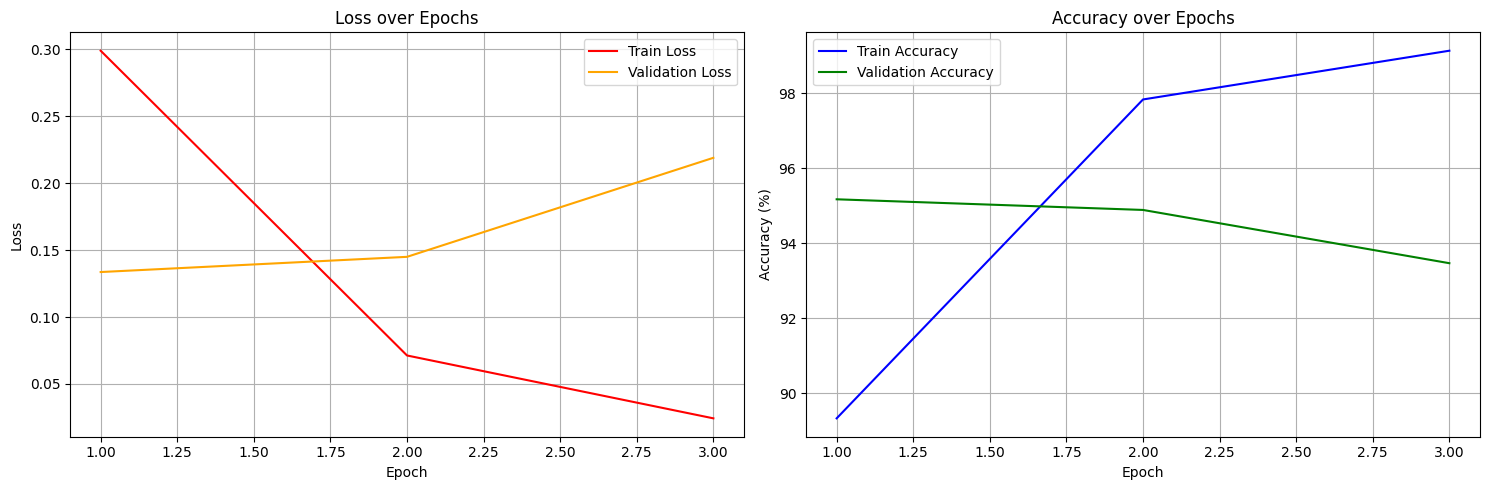

In [24]:
import matplotlib.pyplot as plt
plot_metrics()

<Figure size 1000x800 with 0 Axes>

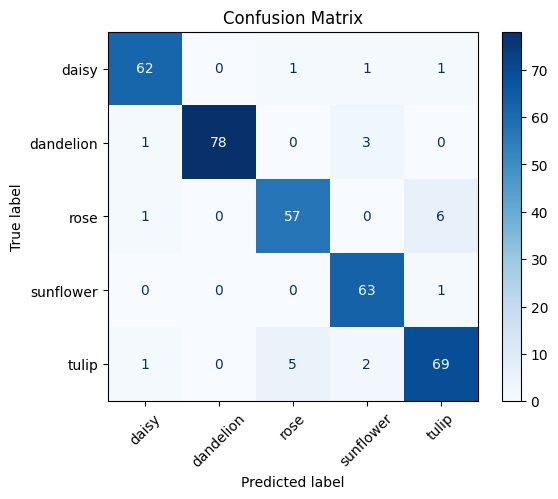

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import numpy as np
import matplotlib.pyplot as plt

# Put model in evaluation mode
model.eval()

# Get true and predicted labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:  # Use test_loader or val_loader
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_dataset.classes)

# Plot
plt.figure(figsize=(10, 8))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

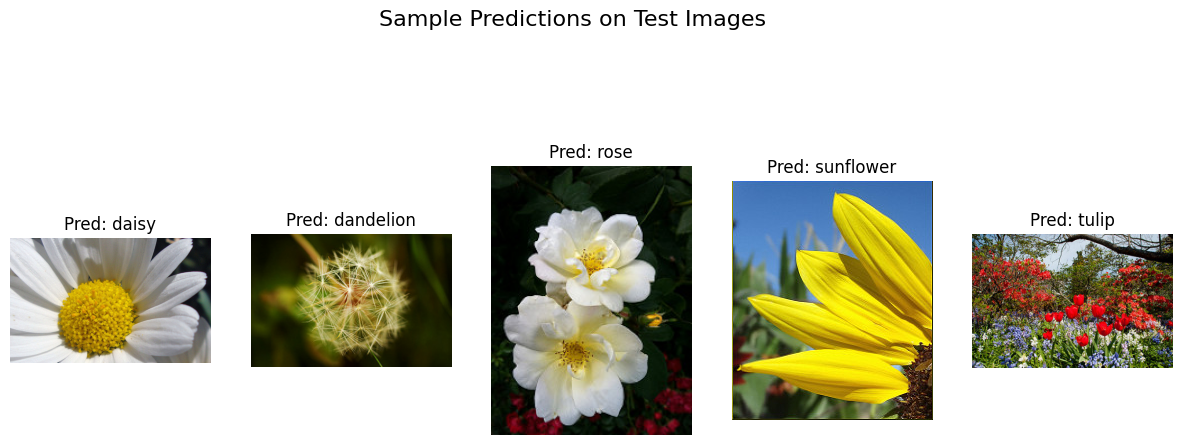

In [26]:
from PIL import Image

# Directory of your test images (adjust as needed)
test_dir = os.path.join(data_dir, "test")

# Same transform as used in training/validation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Get class names from your test dataset
class_names = os.listdir(test_dir)

# Select a few sample images from test set
num_samples = 5
sample_images = []

# Gather sample image paths (1 from each class if possible)
for class_name in class_names:
    class_path = os.path.join(test_dir, class_name)
    image_files = os.listdir(class_path)
    if image_files:
        sample_images.append(os.path.join(class_path, image_files[0]))
    if len(sample_images) >= num_samples:
        break

# Evaluate and display predictions
model.eval()
plt.figure(figsize=(15, 6))

for i, img_path in enumerate(sample_images):
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_class = torch.max(output, 1)

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image)
    plt.title(f"Pred: {class_names[predicted_class.item()]}")
    plt.axis("off")

plt.suptitle("Sample Predictions on Test Images", fontsize=16)
plt.show()

In [27]:
import time
import sys

def fancy_print(text, delay=0.05):
    for char in text:
        sys.stdout.write(char)
        sys.stdout.flush()
        time.sleep(delay)
    print()  # New line

fancy_print("🌟 Thank you for watching this video! 🌟", 0.07)
fancy_print("👍 Please like, ❤️ share, and 🔔 subscribe! 🚀", 0.07)

🌟 Thank you for watching this video! 🌟
👍 Please like, ❤️ share, and 🔔 subscribe! 🚀
